
=============== depth p=1 ===============
Rank  |  Bitstring   | Probability     | Classical Cost
------------------------------------------
1     | 110010010010 | 0.00390         | 4
2     | 110010101010 | 0.00360         | 4
3     | 010011110110 | 0.00260         | 12
4     | 111010000010 | 0.00230         | 4
5     | 010101001010 | 0.00230         | 8
------------------------------------------

=============== depth p=3 ===============
Rank  |  Bitstring   | Probability     | Classical Cost
------------------------------------------
1     | 001001110001 | 0.00280         | 12
2     | 111001111110 | 0.00220         | 6
3     | 111110110001 | 0.00220         | 6
4     | 001110010011 | 0.00210         | 4
5     | 101110000101 | 0.00200         | 20
------------------------------------------

=============== depth p=5 ===============
Rank  |  Bitstring   | Probability     | Classical Cost
------------------------------------------
1     | 000101110110 | 0.00250         | 14
2     | 100

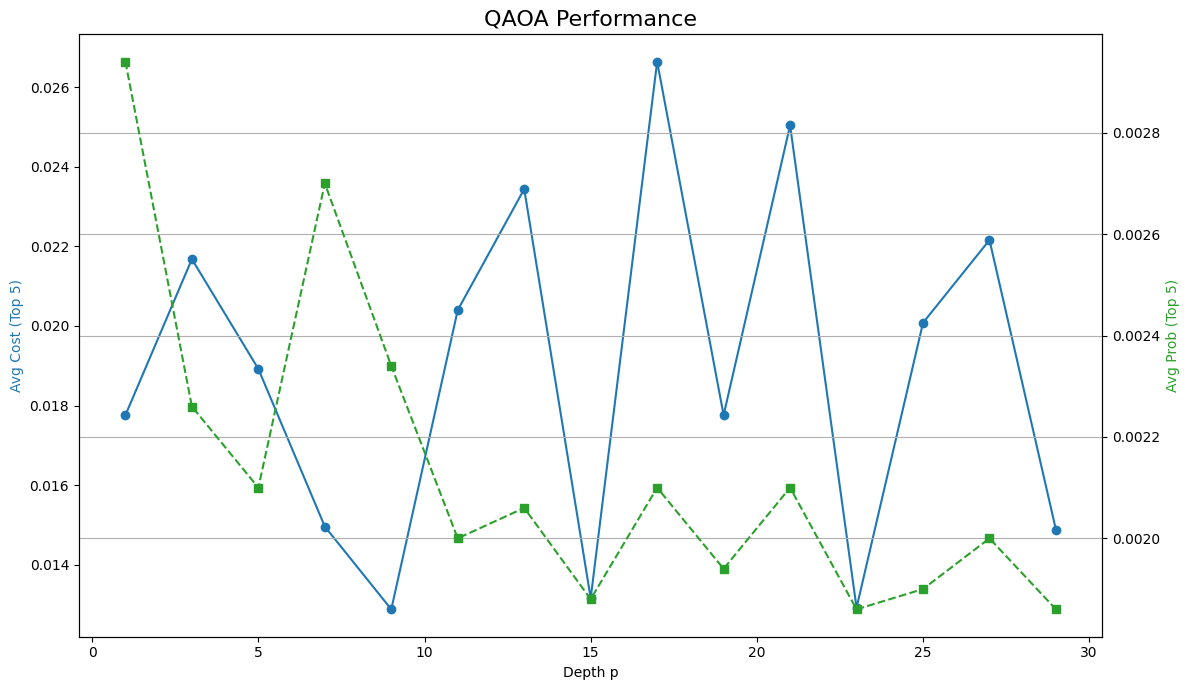

In [ ]:
import collections
import numpy as np
import matplotlib.pyplot as plt
from functools import lru_cache
from itertools import product

from qiskit import transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import AerSimulator
from scipy.optimize import minimize

cubes_default_orientation = [
    {"Front": "G", "Back": "W", "Top": "R", "Bottom": "B", "Left": "R", "Right": "R"},
    {"Front": "W", "Back": "B", "Top": "W", "Bottom": "G", "Left": "R", "Right": "B"},
    {"Front": "R", "Back": "G", "Top": "B", "Bottom": "W", "Left": "R", "Right": "W"},
    {"Front": "R", "Back": "G", "Top": "B", "Bottom": "B", "Left": "W", "Right": "G"}
]

@lru_cache(maxsize=None)
def get_orientation_from_binary_string(cube_idx, b_str):
    initial_orientation = cubes_default_orientation[cube_idx]
    b0, b1, b2 = [int(b) for b in b_str]
    current_orientation = initial_orientation.copy()
    if b0 == 1:
        original = current_orientation.copy()
        current_orientation['Top'], current_orientation['Right'], current_orientation['Bottom'], current_orientation['Left'] = \
            original['Left'], original['Top'], original['Right'], original['Bottom']
    if b1 == 1:
        original = current_orientation.copy()
        current_orientation['Top'], current_orientation['Front'], current_orientation['Bottom'], current_orientation['Back'] = \
            original['Back'], original['Top'], original['Front'], original['Bottom']
    if b2 == 1:
        original = current_orientation.copy()
        current_orientation['Top'], current_orientation['Right'], current_orientation['Bottom'], current_orientation['Left'] = \
            original['Left'], original['Top'], original['Right'], original['Bottom']
    return current_orientation

def calculate_classical_cost(bitstring):
    current_cost = 0
    orientations = [get_orientation_from_binary_string(i, bitstring[3*i:3*i+3]) for i in range(4)]
    tb_counts = collections.defaultdict(int)
    lr_counts = collections.defaultdict(int)
    for o in orientations:
        tb_counts[o['Top']] += 1
        tb_counts[o['Bottom']] += 1
        lr_counts[o['Left']] += 1
        lr_counts[o['Right']] += 1
    for c in ["R", "B", "W", "G"]:
        current_cost += (tb_counts[c] - 2)**2
        current_cost += (lr_counts[c] - 2)**2
    return current_cost

NUM_QUBITS = 12

@lru_cache(maxsize=None)
def get_binary_poly_coeffs(cube_idx, face, color):
    y = np.zeros(8)
    for j, b_vars in enumerate(product([0, 1], repeat=3)):
        b_str = "".join(map(str, b_vars))
        orientation = get_orientation_from_binary_string(cube_idx, b_str)
        if orientation[face] == color:
            y[j] = 1
    M = np.zeros((8, 8))
    for i, z_vars in enumerate(product([0, 1], repeat=3)):
        z0, z1, z2 = z_vars
        M[i, :] = [1, z0, z1, z2, z0*z1, z0*z2, z1*z2, z0*z1*z2]
    coeffs = np.linalg.solve(M, y)
    poly_map = {}
    term_map = [(), (0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)]
    for i, c in enumerate(coeffs):
        if not np.isclose(c, 0):
            poly_map[term_map[i]] = c
    return poly_map

def term_to_pauli(term_indices, coeff, num_qubits):
    op = SparsePauliOp("I" * num_qubits, coeffs=[coeff])
    identity = SparsePauliOp.from_list([("I" * num_qubits, 1)])
    for i in term_indices:
        pauli_str = ["I"] * num_qubits
        pauli_str[num_qubits - 1 - i] = "Z"
        z_i_op = (identity - SparsePauliOp("".join(pauli_str))) * 0.5
        op = op @ z_i_op
    return op

def get_indicator_pauli(cube_idx, face, color, num_qubits):
    poly_coeffs = get_binary_poly_coeffs(cube_idx, face, color)
    total_op = SparsePauliOp("I" * num_qubits, coeffs=[0])
    for local_terms, coeff in poly_coeffs.items():
        global_indices = [t + 3 * cube_idx for t in local_terms]
        pauli_term = term_to_pauli(global_indices, coeff, num_qubits)
        total_op += pauli_term
    return total_op.simplify()

@lru_cache(maxsize=1)
def build_cost_hamiltonian(num_qubits):
    colors = ["R", "B", "W", "G"]
    N_ops = {"TopBottom": {}, "LeftRight": {}}
    for c in colors:
        N_ops["TopBottom"][c] = SparsePauliOp("I" * num_qubits, coeffs=[0])
        N_ops["LeftRight"][c] = SparsePauliOp("I" * num_qubits, coeffs=[0])
    for i in range(4):
        for c in colors:
            N_ops["TopBottom"][c] += get_indicator_pauli(i, 'Top', c, num_qubits)
            N_ops["TopBottom"][c] += get_indicator_pauli(i, 'Bottom', c, num_qubits)
            N_ops["LeftRight"][c] += get_indicator_pauli(i, 'Left', c, num_qubits)
            N_ops["LeftRight"][c] += get_indicator_pauli(i, 'Right', c, num_qubits)
    cost_op = SparsePauliOp("I" * num_qubits, coeffs=[0])
    identity_op = SparsePauliOp("I" * num_qubits, coeffs=[1])
    for group in ["TopBottom", "LeftRight"]:
        for c in colors:
            N_c = N_ops[group][c].simplify()
            term_op = (N_c @ N_c) - (4 * N_c) + (4 * identity_op)
            cost_op += term_op
    return cost_op.simplify()

@lru_cache(maxsize=1)
def build_xy_mixer(num_qubits):
    pauli_terms = []
    for j in range(4):
        q0, q1, q2 = 3 * j, 3 * j + 1, 3 * j + 2
        for a, b in [(q0, q1), (q1, q2), (q2, q0)]:
            xx = ['I'] * num_qubits
            xx[num_qubits - 1 - a] = 'X'
            xx[num_qubits - 1 - b] = 'X'
            pauli_terms.append(("".join(xx), 1.0))
            yy = ['I'] * num_qubits
            yy[num_qubits - 1 - a] = 'Y'
            yy[num_qubits - 1 - b] = 'Y'
            pauli_terms.append(("".join(yy), 1.0))
    return SparsePauliOp.from_list(pauli_terms)

def display_top_states_info(counts, num_states=5):
    total_shots = sum(counts.values())
    print(f"{'Rank':<5} | {'Bitstring':^{NUM_QUBITS}} | {'Probability':<15} | {'Classical Cost'}")
    print("-" * (30 + NUM_QUBITS))
    sorted_items = sorted(counts.items(), key=lambda item: item[1], reverse=True)[:num_states]
    for i, (bitstring, count) in enumerate(sorted_items):
        prob = count / total_shots
        cost = calculate_classical_cost(bitstring)
        print(f"{i+1:<5} | {bitstring:<{NUM_QUBITS}} | {prob:<15.5f} | {cost}")
    print("-" * (30 + NUM_QUBITS))

def optimize_qaoa_params(ansatz, simulator, p):
    def objective(params):
        bound_qc = ansatz.assign_parameters(params)
        bound_qc.measure_all()
        tqc = transpile(bound_qc, simulator, optimization_level=1)
        result = simulator.run(tqc, shots=10000).result()
        counts = result.get_counts()
        total = sum(counts.values())
        return sum((count / total) * calculate_classical_cost(bs) for bs, count in counts.items())

    initial_params = np.random.rand(2 * p) * np.pi
    res = minimize(objective, initial_params, method='COBYLA', options={'maxiter': 5 * p})
    return res.x

def run_qaoa_for_depth(p, cost_hamiltonian, simulator):
    print(f"\n{'='*15} depth p={p} {'='*15}")
    mixer = build_xy_mixer(cost_hamiltonian.num_qubits)
    ansatz = QAOAAnsatz(
        cost_operator=cost_hamiltonian,
        mixer_operator=mixer,
        reps=p
    )
    opt_params = optimize_qaoa_params(ansatz, simulator, p)
    final_circuit = ansatz.assign_parameters(opt_params)
    final_circuit.measure_all()
    final_circuit = transpile(final_circuit, simulator, optimization_level=1)
    result = simulator.run(final_circuit, shots=10000).result()
    counts = result.get_counts()
    display_top_states_info(counts)

    sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]
    total = sum(counts.values())
    avg_cost = sum((calculate_classical_cost(bs) * count / total) for bs, count in sorted_items) / 5
    avg_prob = sum(count / total for _, count in sorted_items) / 5
    return avg_cost, avg_prob

def main(max_depth):
    simulator = AerSimulator()
    cost_hamiltonian = build_cost_hamiltonian(NUM_QUBITS)
    depths, avg_costs, avg_probs = [], [], []
    for p in range(1, max_depth+1, 2):
        cost, prob = run_qaoa_for_depth(p, cost_hamiltonian, simulator)
        depths.append(p)
        avg_costs.append(cost)
        avg_probs.append(prob)

    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax1.set_title('QAOA Performance', fontsize=16)
    ax1.set_xlabel('Depth p')
    ax1.set_ylabel('Avg Cost (Top 5)', color='tab:blue')
    ax1.plot(depths, avg_costs, 'o-', color='tab:blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Avg Prob (Top 5)', color='tab:green')
    ax2.plot(depths, avg_probs, 's--', color='tab:green')
    fig.tight_layout()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main(max_depth=30)



=============== depth p=1 ===============
Rank  |  Bitstring   | Probability     | Classical Cost
------------------------------------------
1     | 001110001111 | 0.00350         | 6
2     | 000001001011 | 0.00310         | 4
3     | 001001001101 | 0.00290         | 12
4     | 001001001111 | 0.00290         | 10
5     | 100100001101 | 0.00280         | 12
------------------------------------------

=============== depth p=2 ===============
Rank  |  Bitstring   | Probability     | Classical Cost
------------------------------------------
1     | 001100101001 | 0.00240         | 4
2     | 101110100001 | 0.00230         | 4
3     | 010011001100 | 0.00220         | 10
4     | 110001100101 | 0.00220         | 4
5     | 100100101100 | 0.00210         | 4
------------------------------------------

=============== depth p=3 ===============
Rank  |  Bitstring   | Probability     | Classical Cost
------------------------------------------
1     | 010101010101 | 0.00310         | 8
2     | 011

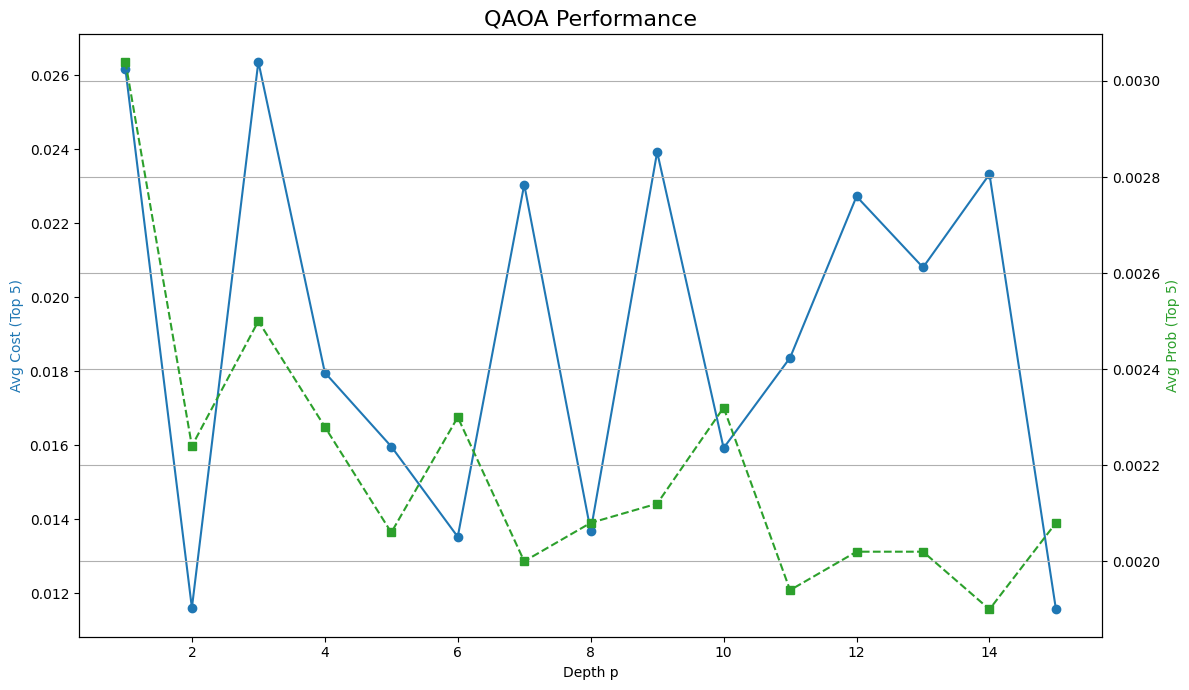

In [26]:
def main(max_depth):
    simulator = AerSimulator()
    cost_hamiltonian = build_cost_hamiltonian(NUM_QUBITS)
    depths, avg_costs, avg_probs = [], [], []
    for p in range(1, max_depth+1, 1):
        cost, prob = run_qaoa_for_depth(p, cost_hamiltonian, simulator)
        depths.append(p)
        avg_costs.append(cost)
        avg_probs.append(prob)

    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax1.set_title('QAOA Performance', fontsize=16)
    ax1.set_xlabel('Depth p')
    ax1.set_ylabel('Avg Cost (Top 5)', color='tab:blue')
    ax1.plot(depths, avg_costs, 'o-', color='tab:blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Avg Prob (Top 5)', color='tab:green')
    ax2.plot(depths, avg_probs, 's--', color='tab:green')
    fig.tight_layout()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main(max_depth=15)